In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
df = pd.read_excel("C:/Users/ASUS/Desktop/Data set.xlsx")

In [4]:
df.head()

,Cancellation,InvoiceNo,New Invoice No,StockCode,Canceled Qty,Not-Canceled Qty,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,1,C536379,536379,D,1,0,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
1,1,C536383,536383,35004C,1,0,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
2,1,C536391,536391,22556,12,0,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
3,1,C536391,536391,21984,24,0,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
4,1,C536391,536391,21983,24,0,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Cancellation      541909 non-null  int64         
 1   InvoiceNo         541909 non-null  object        
 2   New Invoice No    541909 non-null  object        
 3   StockCode         541909 non-null  object        
 4   Canceled Qty      541909 non-null  int64         
 5   Not-Canceled Qty  541909 non-null  int64         
 6   Quantity          541909 non-null  int64         
 7   InvoiceDate       541909 non-null  datetime64[ns]
 8   UnitPrice         541909 non-null  float64       
 9   CustomerID        406829 non-null  float64       
 10  Country           541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 45.5+ MB


In [6]:
df.CustomerID.isnull().sum()

135080

In [7]:
df = df.dropna(subset=['CustomerID'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Cancellation      406829 non-null  int64         
 1   InvoiceNo         406829 non-null  object        
 2   New Invoice No    406829 non-null  object        
 3   StockCode         406829 non-null  object        
 4   Canceled Qty      406829 non-null  int64         
 5   Not-Canceled Qty  406829 non-null  int64         
 6   Quantity          406829 non-null  int64         
 7   InvoiceDate       406829 non-null  datetime64[ns]
 8   UnitPrice         406829 non-null  float64       
 9   CustomerID        406829 non-null  float64       
 10  Country           406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 37.2+ MB


In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  
last_date = df['InvoiceDate'].max() 

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days,  
    'InvoiceNo': 'nunique', 
    'UnitPrice': lambda x: (x * df['Quantity']).sum() 
})

rfm.rename(columns={
    'InvoiceDate': 'Recency', 
    'InvoiceNo': 'Frequency', 
    'UnitPrice': 'Monetary'
}, inplace=True)



In [10]:
#Ignoring negative or zero monetary values
rfm = rfm[rfm['Monetary'] > 0]

In [11]:
#Calculating the RFM scores
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

In [12]:
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

In [13]:
print(rfm)

            Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
CustomerID                                                                
12347.0           1          7   4310.00       4       4       4       444
12348.0          74          4   1797.24       2       3       4       234
12349.0          18          1   1757.55       3       1       4       314
12350.0         309          1    334.40       1       1       2       112
12352.0          35         11   1545.41       3       4       3       343
...             ...        ...       ...     ...     ...     ...       ...
18280.0         277          1    180.60       1       2       1       121
18281.0         180          1     80.82       1       2       1       121
18282.0           7          3    176.60       4       3       1       431
18283.0           3         16   2094.88       4       4       4       444
18287.0          42          3   1837.28       3       3       4       334

[4318 rows x 7 columns]


# Initiating Kmeans++

In [26]:
from sklearn.cluster import KMeans
import seaborn as sns

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


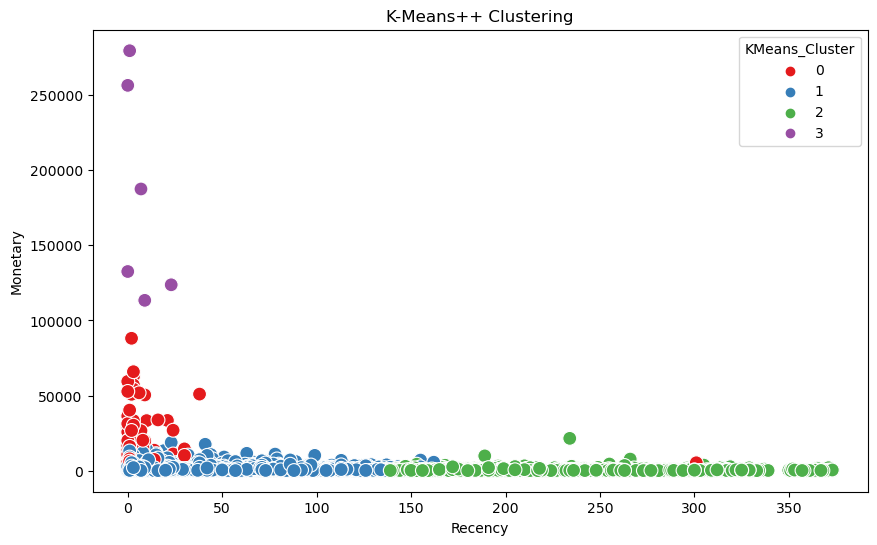

In [38]:
X = rfm[['Recency', 'Frequency', 'Monetary']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='KMeans_Cluster', palette='Set1', s=100)
plt.title('K-Means++ Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.show()

# Initiating DBSCAN

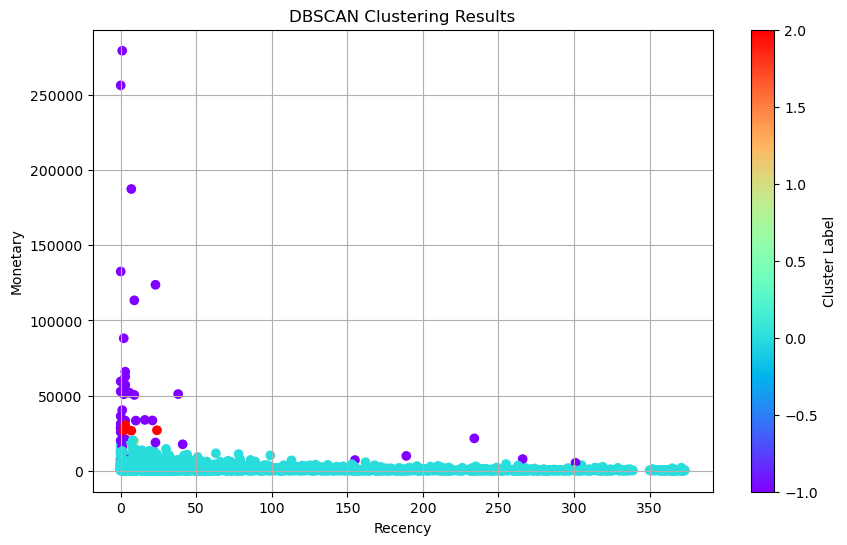

In [33]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm[features])

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_scaled)
rfm['Cluster'] = dbscan.labels_


plt.figure(figsize=(10, 6))
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='rainbow', marker='o')
plt.title('DBSCAN Clustering Results')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.colorbar(label='Cluster Label')
plt.grid()
plt.show()

In [34]:
from sklearn.metrics import silhouette_score

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means++ Silhouette Score: 0.6124901306397893
DBSCAN Silhouette Score: 0.6415673163784144
K-Means++ Cluster Count: 4
DBSCAN Cluster Count: 3


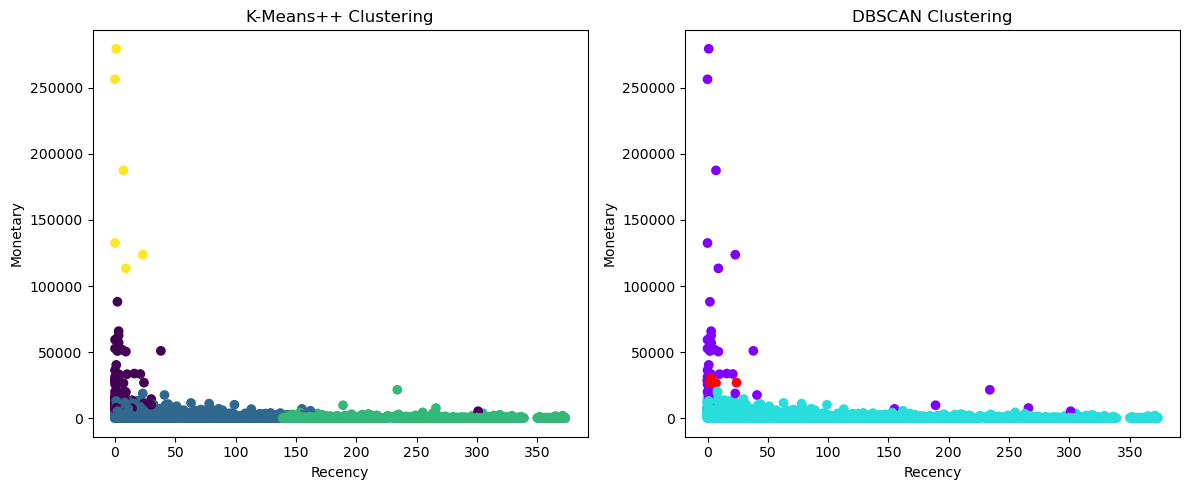

In [36]:
kmeans_labels = kmeans.fit_predict(X_scaled)
dbscan_labels = dbscan.fit_predict(X_scaled)

rfm['KMeans_Cluster'] = kmeans_labels
rfm['DBSCAN_Cluster'] = dbscan_labels

kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
dbscan_silhouette = silhouette_score(X_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else -1

print(f"K-Means++ Silhouette Score: {kmeans_silhouette}")
print(f"DBSCAN Silhouette Score: {dbscan_silhouette}")

kmeans_clusters = len(np.unique(kmeans_labels))
dbscan_clusters = len(np.unique(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

print(f"K-Means++ Cluster Count: {kmeans_clusters}")
print(f"DBSCAN Cluster Count: {dbscan_clusters}")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['KMeans_Cluster'], cmap='viridis', marker='o')
plt.title('K-Means++ Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')

plt.subplot(1, 2, 2)
plt.scatter(rfm['Recency'], rfm['Monetary'], c=rfm['DBSCAN_Cluster'], cmap='rainbow', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('Recency')
plt.ylabel('Monetary')

plt.tight_layout()
plt.show()
